<img src="./Helio-SQL-to-Text-Plugin.png" width=400/>

# Finetuning Gemma Model for a SQL Query Assistant

In this notebook we demonstrate how to build a Finetune model using [NVIDIA NIM Microservices](https://build.nvidia.com). We create a fine-tune model using Google's Gemma using QLora where we train the weights of the model to merge with the original model. Model is fine-tuned using the [synthetic text to sql data from hugging face](https://huggingface.co/datasets/philschmid/gretel-synthetic-text-to-sql).  You can checkout the finished product - [Helio SQL Assistant](https://chromewebstore.google.com/detail/helio-sql-query-assistant/mkiekcaeimlglkkenkfomllindljjihe?hl=en-US&utm_source=ext_sidebar). I have adapted this from Google's doc [here](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora)

![SFT techniques.jpg](./SFT_techniques.jpg). 

In [1]:
# Install Pytorch & other libraries
# %pip install "torch>=2.4.0" tensorboard

# # Install Gemma release branch from Hugging Face
# %pip install "transformers>=4.51.3"

# # Install Hugging Face libraries
# %pip install  --upgrade \
#   "datasets==3.3.2" \
#   "accelerate==1.4.0" \
#   "evaluate==0.4.3" \
#   "bitsandbytes==0.45.3" \
#   "trl==0.15.2" \
#   "peft==0.14.0" \
#   protobuf \
#   sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
# %pip install flash-attn

In [5]:
# Load the data from Hugging Face Datasets library and create a SQL template
from datasets import load_dataset

# System message for the assistant
system_message = """You are a text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA."""

# User prompt that combines the user query and the schema
user_prompt = """Given the <USER_QUERY> and the <SCHEMA>, generate the corresponding SQL command to retrieve the desired data, considering the query's syntax, semantics, and schema constraints.

<SCHEMA>
{context}
</SCHEMA>

<USER_QUERY>
{question}
</USER_QUERY>
"""
def create_conversation(sample):
  return {
    "messages": [
      # {"role": "system", "content": system_message},
      {"role": "user", "content": user_prompt.format(question=sample["sql_prompt"], context=sample["sql_context"])},
      {"role": "assistant", "content": sample["sql"]}
    ]
  }

# Load dataset from the hub
dataset = load_dataset("philschmid/gretel-synthetic-text-to-sql", split="train")
dataset = dataset.shuffle().select(range(12500))

# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

# Print formatted user prompt
print(dataset["train"][345]["messages"][1]["content"])

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

SELECT region, AVG(cloud_cover) FROM Satellite_Images WHERE date BETWEEN '2022-01-01' AND '2022-01-15' AND region = 'Southeast' GROUP BY region HAVING COUNT(*) > 2;


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To Access <code>Gemma</code>Model<code>on Hugging Face</code> files:</b> 1) click on the <a href="https://huggingface.co">Hugging Face</a> and create an account and then 2) click on <em>"Profile"</em> then follow the steps to generate an API keys 3) <code>pip install -U "huggingface_hub[cli]"</code> and Set the<code>Token</code>

<p> ⬇ &nbsp; <b>Download the models:</b> 1) Search for <a href="https://huggingface.co/google/gemma-3-1b-pt">Gemma Model</a> and then 2) click on <em>"Accept the use policy"</em> by selecting <em>"Model"</em>.</p>

<p> 📒 &nbsp; <b>Create a NVIDIA NIM Account:</b>, 1) Visit the  <a href="https://build.nvidia.com">to create an account</a> 2) <em>"You need to load $5-10"</em> then select one of the A100 GPU microservices.</p>
</div>

In [2]:
# Download the models
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForImageTextToText, BitsAndBytesConfig

# Hugging Face model id
model_id = "google/gemma-3-1b-pt" # or `google/gemma-3-4b-pt`, `google/gemma-3-12b-pt`, `google/gemma-3-27b-pt`

# Select model class based on id
if model_id == "google/gemma-3-1b-pt":
    model_class = AutoModelForCausalLM
else:
    model_class = AutoModelForImageTextToText

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] >= 8:
    torch_dtype = torch.bfloat16
else:
    torch_dtype = torch.float16

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch_dtype, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

# BitsAndBytesConfig: Enables 4-bit quantization to reduce model size/memory usage
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=model_kwargs['torch_dtype'],
    bnb_4bit_quant_storage=model_kwargs['torch_dtype'],
)

# Load model and tokenizer
model = model_class.from_pretrained(model_id, **model_kwargs)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it") # Load the Instruction Tokenizer to use the official Gemma template

In [5]:
# Fine tune Gemma Model using TRL and SFTTrainer
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"] # make sure to save the lm_head and embed_tokens as you train the special tokens
)

### Training the model
There several parameters that matters but you only need to pass attention to a few of them. Here is the few of them.
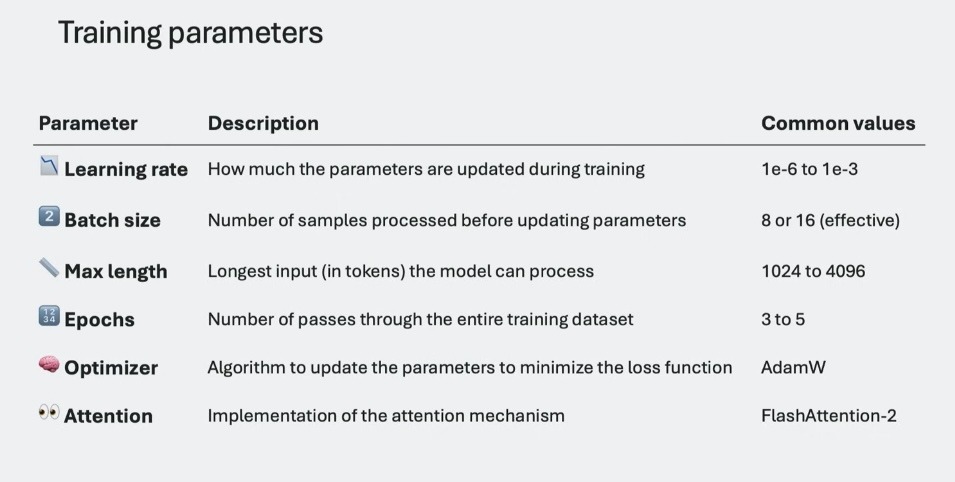

In [6]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="gemma-text-to-sql",         # directory to save and repository id
    max_seq_length=512,                     # max sequence length for model and packing of the dataset
    packing=True,                           # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,   # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

In [7]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    processing_class=tokenizer
)

Converting train dataset to ChatML:   0%|          | 0/10000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [8]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,1.612500
20,0.839300
30,0.685800
40,0.644300
50,0.637300
60,0.623700
70,0.571700
80,0.562800
90,0.581700
100,0.583700


In [9]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

##### When using QLoRA, you only train adapters and not the full model. This means when saving the model during training you only save the adapter weights and not the full model. If you want to save the full model, which makes it easier to use with serving stacks like vLLM or TGI, you can merge the adapter weights into the model weights using the merge_and_unload method and then save the model with the save_pretrained method. This saves a default model, which can be used for inference. [Reference](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora)

In [10]:
#merge the weight with the base model
from peft import PeftModel

# Load Model base model
model = model_class.from_pretrained(model_id, low_cpu_mem_usage=True)

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, args.output_dir)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained("merged_model", safe_serialization=True, max_shard_size="2GB")

processor = AutoTokenizer.from_pretrained(args.output_dir)
processor.save_pretrained("merged_model")

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/tokenizer.model',
 'merged_model/added_tokens.json',
 'merged_model/tokenizer.json')

#### Test and Evaluate. You can also push the model into huggingface for others to use it

#### Login with your Hugging Face credentials
huggingface-cli login

#### Push your model files
huggingface-cli upload account_name/model_name . 

In [3]:
import torch
from transformers import pipeline

model_id = "gemma-text-to-sql"

# Load Model with PEFT adapter
model = model_class.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch_dtype,
  attn_implementation="eager",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)


In [6]:
from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"]))
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
stop_token_ids = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<end_of_turn>")]
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:2], tokenize=False, add_generation_prompt=True)

# Generate our SQL query.
outputs = pipe(prompt, max_new_tokens=256, do_sample=False, temperature=0.1, top_k=50, top_p=0.1, eos_token_id=stop_token_ids, disable_compile=True)

# Extract the user query and original answer
print(f"Context:\n", re.search(r'<SCHEMA>\n(.*?)\n</SCHEMA>', test_sample['messages'][0]['content'], re.DOTALL).group(1).strip())
print(f"Query:\n", re.search(r'<USER_QUERY>\n(.*?)\n</USER_QUERY>', test_sample['messages'][0]['content'], re.DOTALL).group(1).strip())
print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Context:
 CREATE TABLE production_data (year INT, element VARCHAR(10), quantity INT); INSERT INTO production_data (year, element, quantity) VALUES (2018, 'Holmium', 20), (2019, 'Holmium', 22), (2020, 'Holmium', 24), (2021, 'Holmium', 26);
Query:
 How much Holmium was produced in 2020 and 2021?
Original Answer:
SELECT SUM(quantity) FROM production_data WHERE element = 'Holmium' AND year IN (2020, 2021);
Generated Answer:

